In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [ ]:
Pkg.update()
Pkg.instantiate()

In [16]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")
include("experiments.jl")

evaluate_sim (generic function with 1 method)

In [70]:
dt = 0.1
velocity_max = 1.5
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 1.5])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 0.1]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 0.75
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.1]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.1]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 0.75
  inconvenience_ratio: Float64 0.2


In [4]:
robot_initial_state = [5.; -5.; pi / 2; 1.5]
robot_goal_state = [5.; 10.; pi / 2; 0.]
human_initial_state = [5.; 5.; -pi / 2]
human_goal_state = [5.; -10.; -pi / 2]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


# Multi Agent Support

In [5]:
ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# constant velo agents
velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
velo_agent_2 = ConstantVeloAgent([6.5, -2.], [-0.9, 0.4])

add_constant_velocity_agent(ip.ego_planner.incon, velo_agent_1)
add_constant_velocity_agent(ip.other_planner.incon, velo_agent_1)

In [ ]:
# Adds a wall constraint to the planner
wall_1 = Wall("x", 0., 6.7, "less")
wall_constraint(ip, wall_1, "wall_1")
wall_2 = Wall("x", 0.01, 3.2, "greater")
wall_constraint(ip, wall_2, "wall_2")

In [6]:
@time ibr(ip, 10, "ego")

  0.523839 seconds (1.11 M allocations: 97.395 MiB, 9.13% gc time, 55.75% compilation time)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


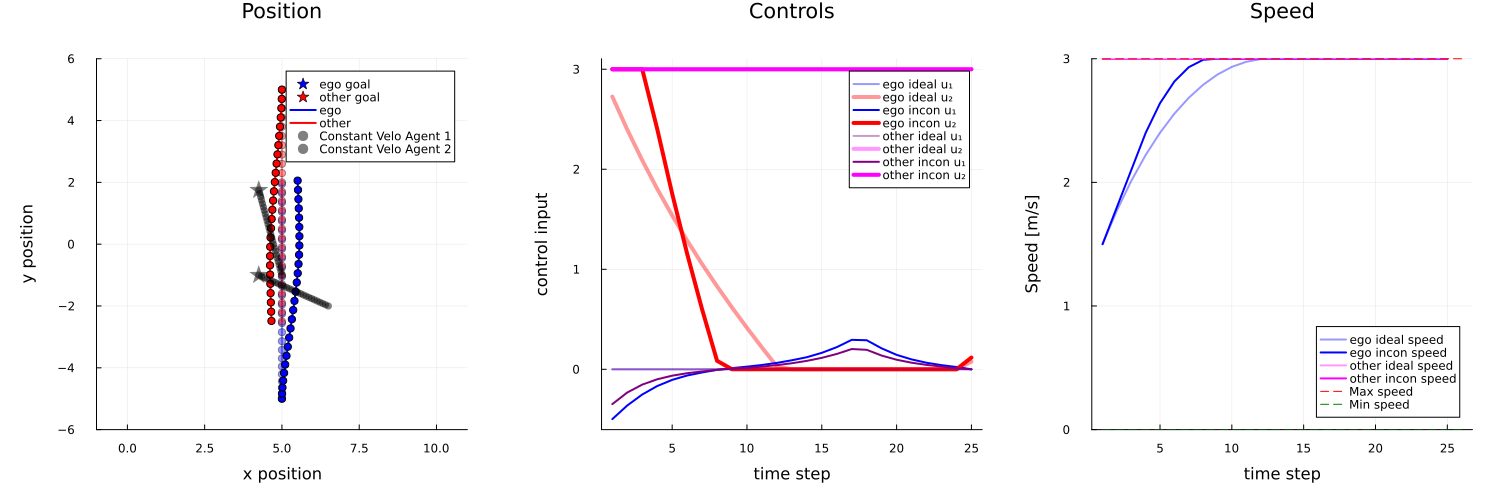

In [7]:
plot_solve_solution(ip, velo_agent_1, velo_agent_2, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

┌ Info: Saved animation to /tmp/jl_Md8XG7YLa1.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_Md8XG7YLa1.gif")
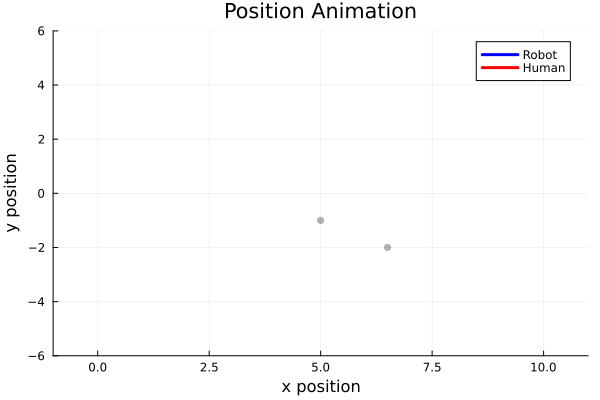

In [8]:
animation(ip, velo_agent_1, velo_agent_2, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Simulation Implementation

In [73]:
robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# constant velo agents
velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
velo_agent_2 = ConstantVeloAgent([4.5, -1.], [0.9, 0.4])
velo_agent_3 = ConstantVeloAgent([8., -4.], [-0.6, 0.2])

add_constant_velocity_agent(robot_ip.ego_planner.incon, velo_agent_1, velo_agent_2)
add_constant_velocity_agent(robot_ip.other_planner.incon, velo_agent_1, velo_agent_2)

human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)
# constant velo agents
# velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
# velo_agent_2 = ConstantVeloAgent([6.5, -2.], [-0.9, 0.4])

add_constant_velocity_agent(human_ip.ego_planner.incon, velo_agent_1, velo_agent_2)
add_constant_velocity_agent(human_ip.other_planner.incon, velo_agent_1, velo_agent_2)

In [72]:
# Adds a wall constraint to the planner
wall_1 = Wall("x", 0., 6.7, "less")
wall_constraint(ip, wall_1, "wall_1")
wall_2 = Wall("x", 0.01, 3.2, "greater")
wall_constraint(ip, wall_2, "wall_2")

26-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.GreaterThan{Float64}}, ScalarShape}}:
 x[1,1] - 0.01 x[1,2] ≥ 4.2
 x[2,1] - 0.01 x[2,2] ≥ 4.2
 x[3,1] - 0.01 x[3,2] ≥ 4.2
 x[4,1] - 0.01 x[4,2] ≥ 4.2
 x[5,1] - 0.01 x[5,2] ≥ 4.2
 x[6,1] - 0.01 x[6,2] ≥ 4.2
 x[7,1] - 0.01 x[7,2] ≥ 4.2
 x[8,1] - 0.01 x[8,2] ≥ 4.2
 x[9,1] - 0.01 x[9,2] ≥ 4.2
 x[10,1] - 0.01 x[10,2] ≥ 4.2
 ⋮
 x[18,1] - 0.01 x[18,2] ≥ 4.2
 x[19,1] - 0.01 x[19,2] ≥ 4.2
 x[20,1] - 0.01 x[20,2] ≥ 4.2
 x[21,1] - 0.01 x[21,2] ≥ 4.2
 x[22,1] - 0.01 x[22,2] ≥ 4.2
 x[23,1] - 0.01 x[23,2] ≥ 4.2
 x[24,1] - 0.01 x[24,2] ≥ 4.2
 x[25,1] - 0.01 x[25,2] ≥ 4.2
 x[26,1] - 0.01 x[26,2] ≥ 4.2

In [74]:
robot_params = PlannerParams(robot_ip.ego_planner.incon.hps, robot_ip.ego_planner.incon.opt_params, robot_ip.other_planner.incon.hps, robot_ip.other_planner.incon.opt_params)
human_params = PlannerParams(human_ip.ego_planner.incon.hps, human_ip.ego_planner.incon.opt_params, human_ip.other_planner.incon.hps, human_ip.other_planner.incon.opt_params)
sim_params = IPSimParams(robot_params, human_params)

IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.1]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 0.75
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-0.5624999840177054, -0.5624992397625164, -0.5623841765092976, -0.5622443845552567, -0.562141039665562, -0.5621040816451313, -0.5621356092780445, -0.56222285238671

In [75]:
robot_xs, robot_us, human_xs, human_us = simulate(robot_ip, human_ip, 50, velo_agent_1, velo_agent_2, ibr_iterations=10, leader="other")

([5.0 -5.0 1.5707963267948966 1.5; 5.0 -4.850000078085662 1.5707988586611927 1.4999984382867535; … ; 5.452563613791033 2.3063871511445337 1.6277641276345343 1.4999994858789982; 5.4440230696034035 2.4561437346882395 1.628209298998208 1.4999988614341278], [2.531866296278345e-5 -1.5617132465853326e-5; 0.0001955274601830633 7.090529810655407e-7; … ; 0.005868786992554156 1.3515316490729275e-6; 0.004451713636737737 -6.2444487041224415e-6], [5.0 5.0 -1.5707963267948966; 5.0 4.850000356008241 -1.5707843698689443; … ; 4.830757456343861 -2.341076731863285 -1.5490995493966253; 4.834011708754548 -2.49104101864798 -1.5489922174439892], [0.00011956925952294786 1.4999964399175885; 0.00041744619872782676 1.499995653845904; … ; 0.0013765452339090441 1.4999974414611106; 0.0010733195263618797 1.4999959156475995])

In [76]:
sim_data = SimData(sim_params, robot_xs, robot_us, human_xs, human_us)

SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.1]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 0.75
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-6.795513775478113, -6.659574758533164, -6.522740296641349, -6.385227809999719, -6.247201250688811, -6.108783960197627, -5.97006948530489, -5.8311288415526

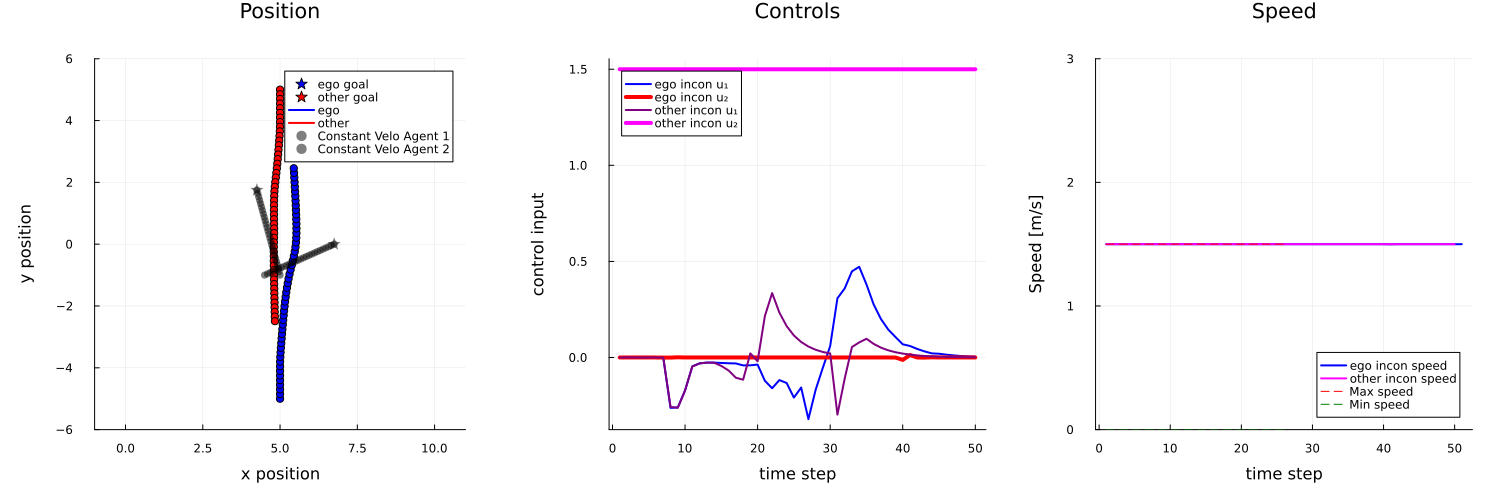

In [77]:
plot_solve_solution(sim_data, velo_agent_1, velo_agent_2, pos_xlims=[-1, 11], pos_ylims=[-6, 6], walls=nothing)

┌ Info: Saved animation to /tmp/jl_Et4HeTAHEN.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_Et4HeTAHEN.gif")
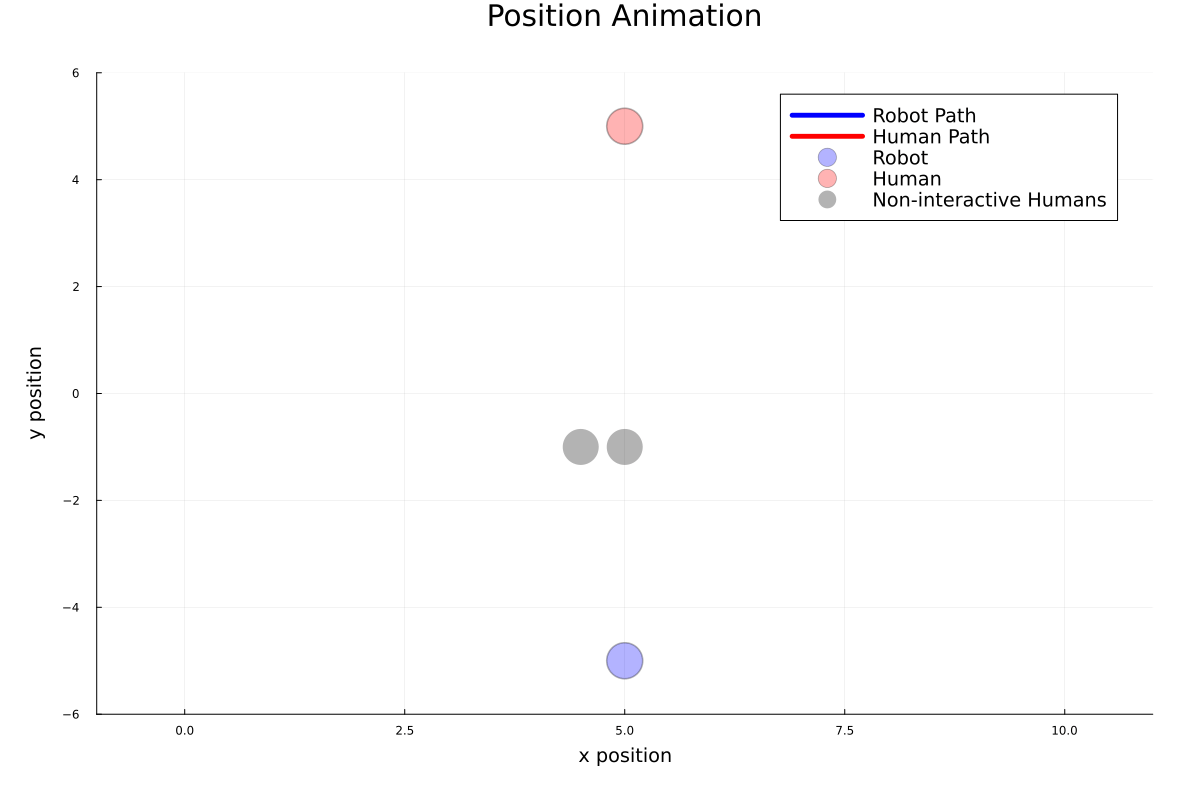

In [78]:
animation(robot_xs, human_xs, 0.1, velo_agent_1, velo_agent_2, pos_xlims=[-1, 11], pos_ylims=[-6, 6], walls=nothing)

In [ ]:
# debugging simulation function

function simulate(ego_ip::InteractionPlanner, other_ip::InteractionPlanner, sim_horizon::Int64, constant_velo_agents::ConstantVeloAgent...; ibr_iterations=3::Int64, leader="ego"::String)
    # Given the IP problem setup of the ego agent and other agent
    # initialize matrices for saving the paths

    ego_dyn = ego_ip.ego_planner.incon.hps.dynamics
    other_dyn = other_ip.ego_planner.incon.hps.dynamics

    velo_agents = collect(constant_velo_agents)

    dt = ego_ip.ego_planner.incon.hps.dynamics.dt

    ego_traj = Vector{Vector{Float64}}(undef, sim_horizon + 1)
    ego_controls = Vector{Vector{Float64}}(undef, sim_horizon)
    other_traj = Vector{Vector{Float64}}(undef, sim_horizon + 1)
    other_controls = Vector{Vector{Float64}}(undef, sim_horizon)

    ego_traj[1] = ego_ip.ego_planner.incon.opt_params.initial_state
    other_traj[1] = other_ip.ego_planner.incon.opt_params.initial_state

    N_velo_agents = length(constant_velo_agents)
    copied_constant_velo_agents = deepcopy(constant_velo_agents)

    slack_vals = []
    ips = []
    ego_data = SaveData(Vector{InteractionPlanner}(undef, sim_horizon))
    other_data = SaveData(Vector{InteractionPlanner}(undef, sim_horizon))


    # Uses MPC function to simulate to a given time horizon
    for i in 1:(sim_horizon)
        ego_state = ego_traj[i]
        other_state = other_traj[i]
        # solve for the next iteration

        ego_control = mpc_step(ego_ip, ego_state, other_state, velo_agents, ibr_iterations=ibr_iterations, leader=leader)
        other_control = mpc_step(other_ip, other_state, ego_state, velo_agents, ibr_iterations=ibr_iterations, leader=leader)

        push!(slack_vals, (value(ego_ip.ego_planner.incon.model[:ϵ]), value(other_ip.ego_planner.incon.model[:ϵ])))
        push!(ips, (deepcopy(ego_ip), deepcopy(other_ip)))
        ego_data.previous_ips[i] = deepcopy(ego_ip)     # store data at each iteration
        other_data.previous_ips[i] = deepcopy(other_ip)     # store data at each iteration

        ego_state = step(ego_dyn, ego_state, ego_control)
        other_state = step(other_dyn, other_state, other_control)
        
        for j in 1:N_velo_agents
            copied_constant_velo_agents[j].pos .+= copied_constant_velo_agents[j].velo * dt
        end

        ego_traj[i+1] = ego_state
        other_traj[i+1] = other_state
        ego_controls[i] = ego_control
        other_controls[i] = other_control

    end

    # cast vector of vectors to matrix for easier plotting
    ego_traj = vector_of_vectors_to_matrix(ego_traj)
    ego_controls = vector_of_vectors_to_matrix(ego_controls)
    other_traj = vector_of_vectors_to_matrix(other_traj)
    other_controls = vector_of_vectors_to_matrix(other_controls)

    ego_traj, ego_controls, other_traj, other_controls, (slack_vals, constant_slack_vals, ips, ego_data, other_data)
end

In [ ]:
# setup for problem with extra slack value for constant velo agents. Mostly for debugging purposes

function InconvenienceProblem(dyn::Dynamics, hps::PlannerHyperparameters, opt_params::PlannerOptimizerParams)
    n = dyn.state_dim
    m = dyn.ctrl_dim
    N = hps.time_horizon
    radius = hps.collision_radius
    solver = opt_params.solver

    if solver == "ECOS"
        model = Model(ECOS.Optimizer)
    elseif solver == "HiGHS"
        model = Model(HiGHS.Optimizer)
    elseif solver == "Gurobi"
        model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    end
    model[:x] = @variable(model, x[1:N+1,1:dyn.state_dim], base_name="x")
    model[:u] = @variable(model, u[1:N,1:dyn.ctrl_dim], base_name="u")
    model[:ϵ] = @variable(model, ϵ, base_name="ϵ")
    model[:ζ] = @variable(model, ζ, base_name="ζ")
    xs = matrix_to_vector_of_vectors(model[:x])
    us = matrix_to_vector_of_vectors(model[:u])
    ps = matrix_to_vector_of_vectors(get_position(dyn, model[:x]))

    @objective(model, Min, compute_running_quadratic_cost(xs[1:N], hps.Q, markup=hps.markup) + compute_running_quadratic_cost(us[1:N], hps.R, markup=hps.markup) + compute_quadratic_error_cost(xs[end], opt_params.goal_state, hps.Qt) + hps.trust_region_weight * (compute_running_quadratic_cost(xs - opt_params.previous_states, Matrix{Float64}(I, n, n)) + compute_running_quadratic_cost(us - opt_params.previous_controls, Matrix{Float64}(I, m, m))) + hps.collision_slack * model[:ϵ] + 15 * hps.collision_slack * model[:ζ])

    # slack variable positivity constraint
    model[:con_ϵ] = @constraint(model, ϵ >= 0)
    model[:con_ζ] = @constraint(model, ζ >= 0)

    # initial state constraint
    model[:initial_state] = @constraint(model, xs[1] == opt_params.initial_state, base_name="initial_state")

    # dynamic and collision avoidance constraints
    for t in 1:N
        model[Symbol("linear_dynamics_constraint_$(t)")] = @constraint(model, opt_params.As[t]*xs[t] + opt_params.Bs[t]*us[t] + opt_params.Cs[t] == xs[t+1], base_name="linear_dynamics_constraint_$(t)")
        model[Symbol("collision_avoidance_constraint_$(t)")] = @constraint(model, dot(opt_params.Gs[t], ps[t]) + opt_params.Hs[t] .>= -ϵ, base_name="collision_avoidance_constraint_$(t)")
    end
    t = N+1
    model[Symbol("collision_avoidance_constraint_$(t)")] = @constraint(model, dot(opt_params.Gs[t], ps[t]) + opt_params.Hs[t] .>= -ϵ, base_name="collision_avoidance_constraint_$(t)")

    # control and velocity constraints
    for t in 1:N
        model[Symbol("control_constraints_upper_$(t)")] = @constraint(model, us[t] <= dyn.control_max, base_name="control_constraints_upper_$(t)")
        model[Symbol("control_constraints_lower_$(t)")] = @constraint(model, dyn.control_min <= us[t] , base_name="control_constraints_lower_$(t)")
        model[Symbol("speed_constraints_upper_$(t)")] = @constraint(model, get_speed(dyn, xs[t], us[t]) .<= dyn.velocity_max , base_name="speed_constraints_upper_$(t)")
        model[Symbol("speed_constraints_lower_$(t)")] = @constraint(model, get_speed(dyn, xs[t], us[t]) .>= dyn.velocity_min , base_name="speed_constraints_lower_$(t)")
    end

    # inconvenience budget constraint
    model[:inconvenience_budget] = @constraint(model, compute_convenience_value(dyn, xs, us, opt_params.goal_state, hps.inconvenience_weights) <= opt_params.inconvenience_budget, base_name="inconvenience_budget")
    InconvenienceProblem(model, xs, us, ϵ, hps, opt_params)
end

In [ ]:
# setup for problem with extra slack value for constant velo agents. Mostly for debugging purposes

function update_problem!(problem::InconvenienceProblem, constant_velo_agents::Vector{ConstantVeloAgent})
    model = problem.model
    hps = problem.hps
    opt_params = problem.opt_params
    n = hps.dynamics.state_dim
    m = hps.dynamics.ctrl_dim
    N = hps.time_horizon
    xs = matrix_to_vector_of_vectors(model[:x])
    us = matrix_to_vector_of_vectors(model[:u])
    ps = matrix_to_vector_of_vectors(get_position(hps.dynamics, model[:x]))
    ego_ps = get_position(hps.dynamics, opt_params.previous_states)
    N_velo_agents = length(constant_velo_agents)

    constant_velo_pos = Vector{Vector}(undef, N_velo_agents)
    constant_velo_Gs = Vector{Vector}(undef, N_velo_agents)
    constant_velo_Hs = Vector{Vector}(undef, N_velo_agents)

    for i in 1:N_velo_agents
        constant_velo_pos[i] = get_constant_velocity_agent_positions(problem, constant_velo_agents[i])
        constant_velo_Gs[i] = linearize_collision_avoidance(ego_ps, constant_velo_pos[i])
        constant_velo_Hs[i] = collision_avoidance_constraint(2., ego_ps, constant_velo_pos[i]) - dot.(constant_velo_Gs[i], ego_ps)
    end

    delete_and_unregister(model, :initial_state)
    model[:initial_state] = @constraint(model, xs[1] == opt_params.initial_state, base_name="initial_state")

    @objective(model, Min, compute_running_quadratic_cost(xs[1:N], hps.Q, markup=hps.markup) + compute_running_quadratic_cost(us[1:N], hps.R, markup=hps.markup) + compute_quadratic_error_cost(xs[end], opt_params.goal_state, hps.Qt) + hps.trust_region_weight * (compute_running_quadratic_cost(xs - opt_params.previous_states, Matrix{Float64}(I, n, n)) + compute_running_quadratic_cost(us - opt_params.previous_controls, Matrix{Float64}(I, m, m))) + hps.collision_slack * model[:ϵ] + 15 * hps.collision_slack * model[:ζ])

    # update dynamics constraints
    for (t, (A,B,C)) in enumerate(zip(opt_params.As, opt_params.Bs, opt_params.Cs))
        delete_and_unregister(model, Symbol("linear_dynamics_constraint_$(t)"))
        model[Symbol("linear_dynamics_constraint_$(t)")] = @constraint(model, A*xs[t] + B*us[t] + C == xs[t+1], base_name="linear_dynamics_constraint_$(t)")
    end

    # update collision avoidance constraints
    for (t, (G, H)) in enumerate(zip(opt_params.Gs, opt_params.Hs))
        delete_and_unregister(model, Symbol("collision_avoidance_constraint_$(t)"))
        model[Symbol("collision_avoidance_constraint_$(t)")] = @constraint(model, dot(opt_params.Gs[t], ps[t]) + opt_params.Hs[t]  .>= -model[:ϵ], base_name="collision_avoidance_constraint_$(t)")
        for i in 1:N_velo_agents
            delete_and_unregister(model, Symbol("constant_velo_avoidance_agent_$(i)_$(t)"))
            model[Symbol("constant_velo_avoidance_agent_$(i)_$(t)")] = @constraint(model, dot(constant_velo_Gs[i][t], ego_ps[t]) + constant_velo_Hs[i][t] .>= -model[:ζ], base_name="constant_velo_avoidance_agent_$(i)_$(t)")
        end
    end

    # update inconvenience budget constraint
    # set_normalized_rhs(model[:inconvenience_budget], opt_params.inconvenience_budget)     # this had issues
    delete_and_unregister(model, :inconvenience_budget)
    model[:inconvenience_budget] = @constraint(model, compute_convenience_value(problem.hps.dynamics, xs, us, opt_params.goal_state, hps.inconvenience_weights) <= opt_params.inconvenience_budget, base_name="inconvenience_budget")
end

In [ ]:
# setup for problem with extra slack value for constant velo agents. Mostly for debugging purposes

function add_constant_velocity_agent(problem::InconvenienceProblem, constant_velo_agents::ConstantVeloAgent...)
    opt_params = problem.opt_params
    dyn = problem.hps.dynamics
    N = problem.hps.time_horizon
    dt = problem.hps.dynamics.dt
    model = problem.model
    N_velo_agents = length(constant_velo_agents)

    constant_velo_pos = Vector{Vector}(undef, N_velo_agents)
    constant_velo_Gs = Vector{Vector}(undef, N_velo_agents)
    constant_velo_Hs = Vector{Vector}(undef, N_velo_agents)

    previous_states = opt_params.previous_states
    ego_ps = get_position(dyn, previous_states)

    for i in 1:N_velo_agents
        constant_velo_pos[i] = get_constant_velocity_agent_positions(problem, constant_velo_agents[i])
        constant_velo_Gs[i] = linearize_collision_avoidance(ego_ps, constant_velo_pos[i])
        constant_velo_Hs[i] = collision_avoidance_constraint(2., ego_ps, constant_velo_pos[i]) - dot.(constant_velo_Gs[i], ego_ps)
    end

    for t in 1:N+1
        for i in 1:N_velo_agents
            model[Symbol("constant_velo_avoidance_agent_$(i)_$(t)")] = @constraint(model, dot(constant_velo_Gs[i][t], ego_ps[t]) + constant_velo_Hs[i][t] .>= -model[:ζ], base_name="constant_velo_avoidance_agent_$(i)_$(t)")
        end
    end      
end